In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Subtract, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import tensorflow_addons as tfa
from tqdm.notebook import tqdm

from learning_wavelets.models.learnlet_model import Learnlet

2022-04-20 15:52:36.707398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 15:52:36.707440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
noise_std_train = (0, 55)
noise_std_val = 30
batch_size = 32
im_size = 128

# Code to generate a dataset that contains images with vertical lines and others with horizontal lines
def generate_images(im_size=128, prop_bands=0.2):
    while True:
        im = np.zeros((im_size, im_size), dtype=np.float64)
        band_locations = np.random.randint(0, im_size, int(prop_bands * im_size))
        p = np.random.uniform() # between 0 and 1
        if p >= 0.5:
          im[:, band_locations] = 1.0
        else:
          im[band_locations, :] = 1.0
        yield im

In [3]:
vert_hor_ds = tf.data.Dataset.from_generator(
    generate_images, 
    tf.float32, 
    tf.TensorShape([im_size, im_size]),
    args=(im_size, 0.2)
).map(lambda x: x[..., None], num_parallel_calls=tf.data.experimental.AUTOTUNE)

def add_noise_function(noise_std_range):
    if not isinstance(noise_std_range, tuple):
        noise_std_range = (noise_std_range, noise_std_range)
    def add_noise(image):
        noise_std = tf.random.uniform(
            (1,),
            minval=noise_std_range[0],
            maxval=noise_std_range[1],
        )
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_std/255, dtype=tf.float32)
        return (image + noise, noise_std/255)
    return add_noise

add_noise_train = add_noise_function(noise_std_train)
add_noise_val = add_noise_function(noise_std_val)

vert_hor_ds_train = vert_hor_ds.map(
    lambda patch: (add_noise_train(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

vert_hor_ds_val = vert_hor_ds.map(
    lambda patch: (add_noise_val(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2022-04-20 15:52:39.236307: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libnvidia-fatbinaryloader.so.418.39: cannot open shared object file: No such file or directory
2022-04-20 15:52:39.236343: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 15:52:39.236374: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zaccharie-Latitude-7490): /proc/driver/nvidia/version does not exist
2022-04-20 15:52:39.236674: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 16, 
        'mixing_details': False,    
        'skip_connection': True,
        'kernel_size': 5,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
        'kernel_size': 5,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 1,
    'clip': False,
}


model=Learnlet(**run_params)
model.compile(optimizer=Adam(lr=1e-3), loss='mse')


In [12]:
history = model.fit(
    vert_hor_ds_train,
    steps_per_epoch=1,  
    epochs=200, 
    batch_size=batch_size,
)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.1418
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.1583
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.1369
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 0.1152
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.1106
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.0887
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 0.0868
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: 0.0706
Epoch 9/200
1/1 [==============================] - 1s 1s/step - loss: 0.0700
Epoch 10/200
1/1 [==============================] - 1s 1s/step - loss: 0.0635
Epoch 11/200
1/1 [==============================] - 1s 1s/step - loss: 0.0537
Epoch 12/200
1/1 [==============================] - 1s 1s/step - loss: 0.0503
Epoch 13/200
1/1 [==============================] - 1s 1s/step - loss: 0.

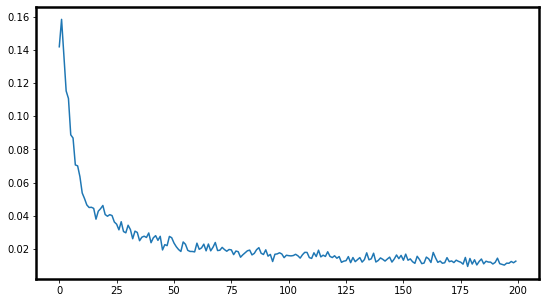

In [13]:
plt.plot(history.history['loss'])

In [14]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.linewidth"] = 2.50

In [15]:
model.layers[0]

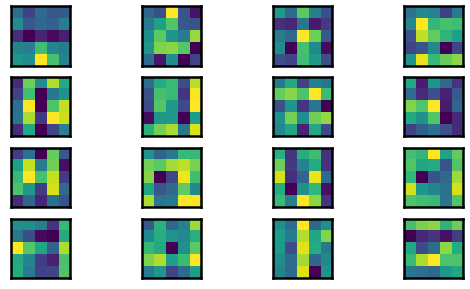

In [20]:
analysis_kernels = np.zeros((5,5,5,1,16))
synthesis_kernels = np.zeros((5,5,5,17,1))
for i in range(5):
  analysis_kernels[i] = np.copy(model.layers[0].convs_detail_tiling[i].get_weights())

for i in range(5):
  synthesis_kernels[i] = np.copy(model.layers[2].convs_groupping[i].get_weights())
base_f = 4
scale = 3

fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
for i in range(base_f):
  for j in range(base_f):
    axs[i, j].imshow(np.squeeze(analysis_kernels[scale, ..., i * base_f + j]))
    axs[i, j].get_xaxis().set_ticks([])
    axs[i, j].get_yaxis().set_ticks([])

# fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
# for i in range(base_f):
#   for j in range(base_f):
#     axs[i, j].imshow(np.squeeze(synthesis_kernels[scale, ..., i * base_f + j, :]))
#     axs[i, j].get_xaxis().set_ticks([])
#     axs[i, j].get_yaxis().set_ticks([])